In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from IPython.display import display, Markdown
def short_print(text):
    display(Markdown(text+'\n'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
from reddit_thread_scraper import fetch_all_posts, build_dataframe_from_posts

# import dataset
thread_name = 'AmItheAsshole'
posts_num = 25000

posts = fetch_all_posts(thread_name, posts_num)

df = build_dataframe_from_posts(posts)

In [ ]:
df.head()

In [ ]:
df['NTA'] = np.where(df['first_comment'].str.contains('NTA'), 1, 0)

df['text'] = df[ 'text' ].apply( str )
df['text_len'] = df[ 'text' ].apply( len )

# Consider only texts shorter than appr. 512 tokens. 
df = df[ (df['text_len'] < 500*4) & (df['num_upvotes'] > 1) ].copy()

df['first_comment'] = df[ 'first_comment' ].apply( str )
df['first_comment_len'] = df[ 'first_comment' ].apply( len )

df_short = df[ (df['first_comment_len'] > 5*4)  ]

## Text clustering. Why dendrogram?

The main reason is the Hierarchical Nature of AITA Topics.

AITA posts tend to have complex themes, often involving nuanced relationships, emotions, and interactions. Hierarchical clustering allows for building a tree-like structure (dendrogram). That groups similar posts at multiple levels, and texts are represented by clusters that branch out into more specific subclusters.


In [3]:
from sentence_transformers import SentenceTransformer

embedding_model_name = 'mixedbread-ai/mxbai-embed-large-v1'

embedding_model = SentenceTransformer(embedding_model_name)

embeddings = embedding_model.encode(df_short['text'].to_list())
df_short['text_embeddings'] = embeddings.tolist()

2024-09-16 20:12:11.005805: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 20:12:11.008351: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-16 20:12:11.014841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 20:12:11.025067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 20:12:11.028040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 20:12:11.037070: I tensorflow/core/platform/cpu_feature_gu

In [4]:
from sklearn.decomposition import PCA

embeddings = np.array(df_short['text_embeddings'].tolist())

# Fit PCA to the data
pca = PCA().fit(embeddings)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1 

print(f"Number of components that explain 95% of variance: {n_components}")

# Apply PCA to reduce the dimensions
pca = PCA(n_components=n_components, random_state=101) 

reduced_embeddings = pca.fit_transform(embeddings)

Number of components that explain 95% of variance: 281


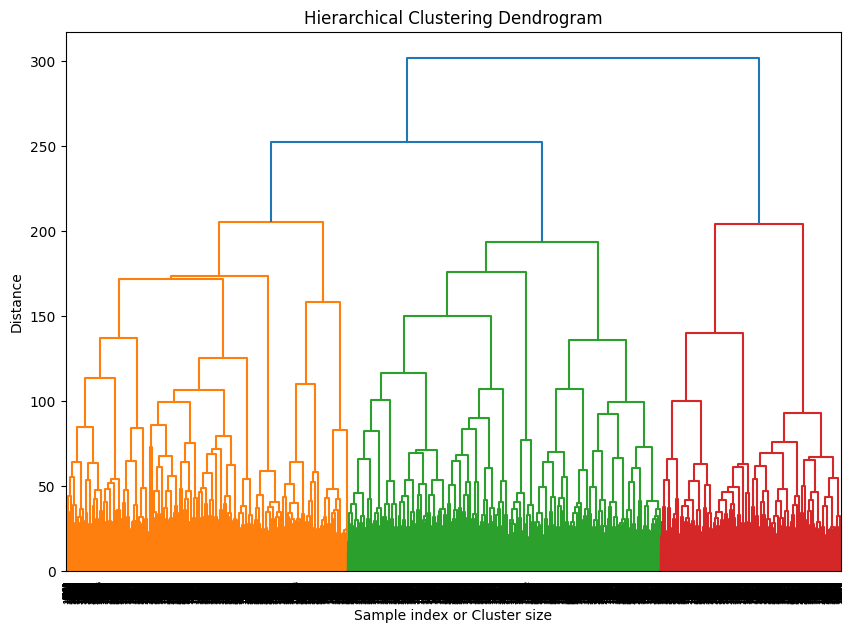

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Perform hierarchical/agglomerative clustering
linked = linkage(reduced_embeddings, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or Cluster size')
plt.ylabel('Distance')
plt.show()

In [6]:
# Maximum linkage distance (the largest t value)
max_t = np.max(linked[:, 2])
print(f"Maximum linkage distance: {max_t}")

# Define percentage thresholds for cutting the dendrogram
thresholds = [0.8, 0.6, 0.4]  

for threshold in thresholds:
    # Calculate the distance at this percentage threshold
    t_value = threshold * max_t
    
    # Apply hierarchical clustering with this threshold
    clusters = fcluster(linked, t=t_value, criterion='distance')
    
    # Print or analyze the number of clusters
    n_clusters = len(np.unique(clusters))
    print(f"Threshold: {threshold*100}% | Number of clusters: {n_clusters}")
    df_short[f'cluster_{n_clusters}'] = clusters


Maximum linkage distance: 302.0119029259698
Threshold: 80.0% | Number of clusters: 3
Threshold: 60.0% | Number of clusters: 6
Threshold: 40.0% | Number of clusters: 15


In [7]:
list_of_clusters = [col for col in df_short.columns if col.startswith('cluster_')]

pd.crosstab(df_short[list_of_clusters[0]], df_short[list_of_clusters[1]])

cluster_6,1,2,3,4,5,6
cluster_3,,,,,,
1,1491,1461,0,0,0,0
2,0,0,2088,3059,0,0
3,0,0,0,0,1095,3551


In [8]:
pd.crosstab(df_short[list_of_clusters[1]], df_short[list_of_clusters[2]])

cluster_15,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
cluster_6,,,,,,,,,,,,,,,
1,1491,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,613,848,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1191,897,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,422,1021,1616,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,473,622,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,460,275,1464,436,916


## The topic of the drama:

### Keywords: Patterns vs. Embeddings 

Extracting Keywords with KeyBERT and SpaCy

AITA posts are were messy and often vague, so finding to compress the information is paramout. There are a number of methods, but in this project we are considering two: semantic similarity and extracting tyical patterns.

**Why SpaCy?**

spaCy allowes to extract syntactic patterns like noun or adjective phrases, which are useful in capturing repeated structures in like "bad decision" or "family conflict."

**Why KeyBERT?**

KeyBERT uses embeddings to capture the contextual meaning of the text. This is especially useful when processing multiple texts that don't necessarily use the same words or phrases but still revolve around the same underlying topic.



### - First, we are looking for recurring patterns within each post.

In [9]:
import spacy
from spacy.matcher import Matcher

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
# Initialize matcher
matcher = Matcher(nlp.vocab)

def get_word_paterns( text, matcher=matcher):
    pattern = [{"POS": "NOUN", "OP": "+"}]  
    matcher.add("NOUN_PHRASES", [pattern])

    adj_noun_pattern = [
        {"POS": "ADJ", "OP": "+"},  
        {"POS": "NOUN", "OP": "+"} 
    ]

    matcher.add("ADJ_NOUN_PHRASE", [adj_noun_pattern])

    doc = nlp(text)

    matches = matcher(doc)
    keywords = [doc[start:end].text for match_id, start, end in matches]

    unique_phrases = set(keywords)
    filtered_phrases = list(unique_phrases)
    words_to_remove = set()

    for phrase in filtered_phrases:
        words_in_phrase = phrase.split()
        if len(words_in_phrase) > 1:
            words_to_remove.update(words_in_phrase)

    final_keywords = [phrase for phrase in filtered_phrases if phrase not in words_to_remove]

    return ' '.join(final_keywords)

df_short['keywords'] = df_short['text'].apply( lambda x: get_word_paterns(x) ) 


### - Second, we are looking for keywords, summarizing a whole cluster of posts

In [10]:
from keybert import KeyBERT

kw_model = KeyBERT()

def get_KeyBert(text, kw_model=kw_model):
    keywords = kw_model.extract_keywords(text, 
                                         keyphrase_ngram_range=(1,2), 
                                         stop_words='english', 
                                         use_maxsum=False, 
                                         top_n=30)
    keywords = [ keyword[0] for keyword in keywords ]

    return ' '.join(keywords)


In [11]:
clusters_keyword = []

# Make doulble check all patterns are converted into strings
df_short['keywords'] = df_short['keywords'].apply( str )

# Iterate over all cluster columns that start with 'cluster_'
for split in [col for col in df_short.columns if col.startswith('cluster_')]:
    # Group by cluster and apply KeyBERT to extract keywords relevant to the whole group of texts
    cluster_keywords = df_short.groupby(split)['keywords'].apply(
        lambda texts: get_KeyBert(' '.join(texts))
    )
    
    clusters_keyword.append(cluster_keywords.tolist())


### Draw it out

In [12]:
from matplotlib.patches import Rectangle

# Function to keep only nouns and lemmatize them
def text_nouns(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Get POS tags for each word
    tags = nltk.pos_tag(words)
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Keep only nouns and lemmatize
    nouns = [lemmatizer.lemmatize(word, pos=wordnet.NOUN) for word, tag in tags if tag.startswith('NN')]
    return ' '.join(nouns)

# Updated word cloud function that returns the word cloud object for plotting
def word_cloud(list_of_text, top_n_words=10):
    # Create a CountVectorizer to count word frequencies
    top_topics_vectorizer = CountVectorizer(stop_words='english', preprocessor=text_nouns)
    
    # Fit and transform the text data for the specific cluster
    top_1 = top_topics_vectorizer.fit_transform([list_of_text])
    
    cluster_words = pd.DataFrame({
        'word': top_topics_vectorizer.get_feature_names_out(),  
        'counts': top_1.toarray().sum(axis=0)
    })
    
    # Sort by word counts and take the top_n_words most common words
    cluster_words = cluster_words.sort_values(by='counts', ascending=False).head(top_n_words)
        
    # Convert dataframe to dictionary for word cloud generation
    word_counts = dict(zip(cluster_words['word'], cluster_words['counts']))
    
    # Generate word cloud
    wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(word_counts)
    
    # Generate top 3 words to represent the topic
    top_3 = ' - '.join(cluster_words['word'][0:3].tolist())
    
    return wordcloud, top_3

# Draw all word clouds in one row
def draw_all_wordclouds(clusters_keyword, top_n_words=10):
    cluster_theme = {}
    num_clusters = len(clusters_keyword)
    
    # Set up the plot with 1 row and num_clusters columns, making each plot a square
    fig, axes = plt.subplots(1, num_clusters, figsize=(num_clusters * 6, 6))
    
    # If there's only one cluster, axes won't be an array, so we handle that case
    if num_clusters == 1:
        axes = [axes]
    
    for i in range(num_clusters):
        # Extract texts and generate the word cloud for each cluster
        texts = clusters_keyword[i]
        wordcloud, top_3 = word_cloud(texts, top_n_words)  # Use i + 1 for cluster numbering
        cluster_theme[i + 1] = top_3
        
        # Plot the word cloud on the respective axis
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Cluster {i + 1}: {top_3}', fontsize=10)
        axes[i].axis('off')  # Turn off axis for a clean look

        # Add a black boundary around each word cloud
        rect = Rectangle((0, 0), 1, 1, transform=axes[i].transAxes, color='black', fill=False, lw=3)
        axes[i].add_patch(rect)

    # Adjust layout to ensure titles and plots fit nicely
    plt.tight_layout()
    plt.show()
    
    return cluster_theme

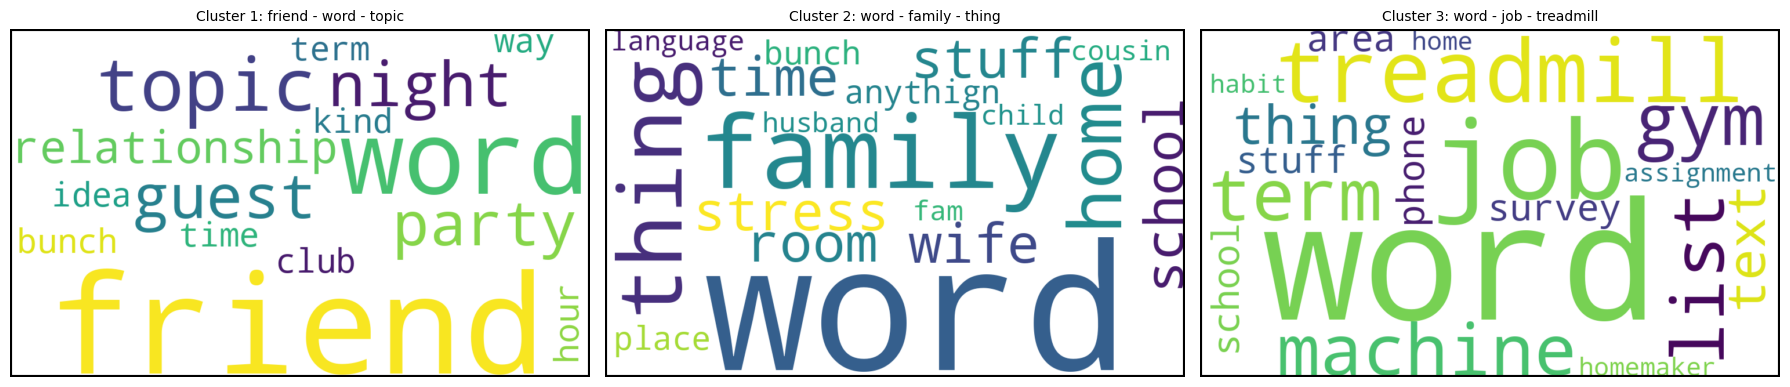

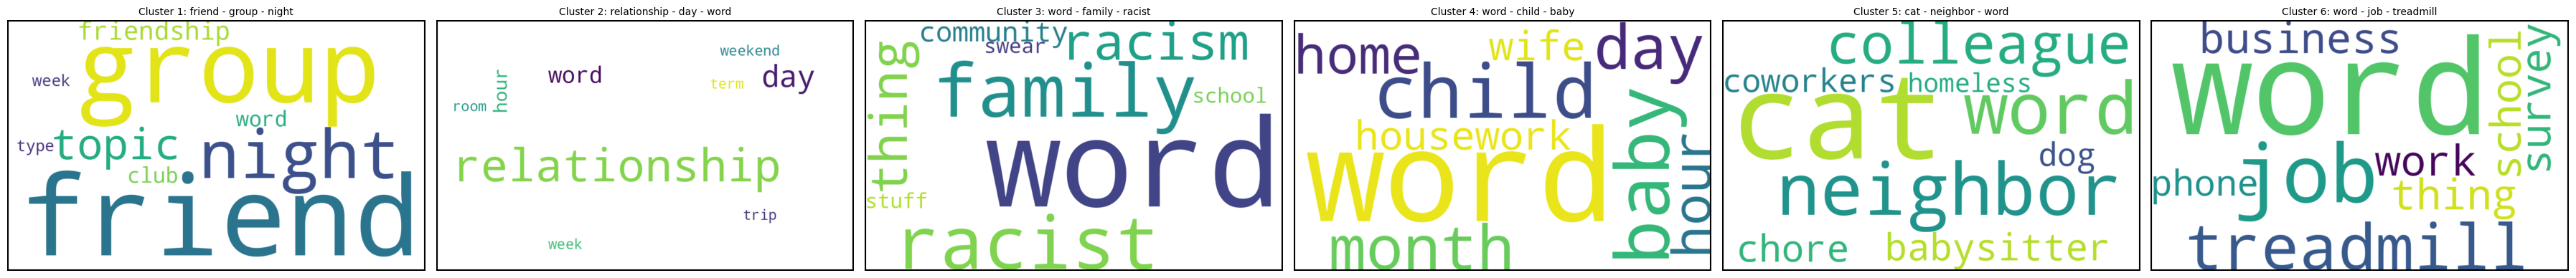

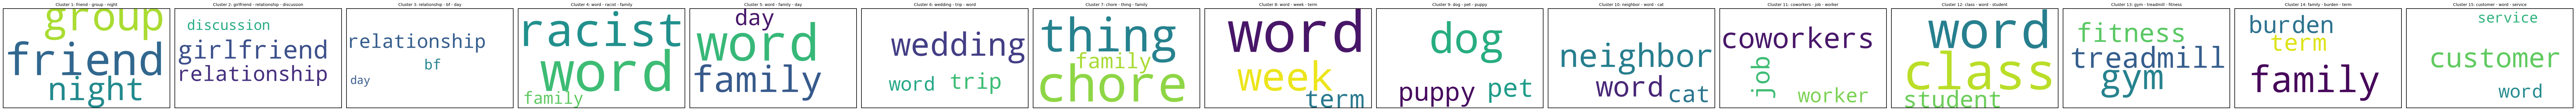

In [13]:
cluster_theme = draw_all_wordclouds(clusters_keyword[0], top_n_words=18)
cluster_theme = draw_all_wordclouds(clusters_keyword[1], top_n_words=9)
cluster_theme = draw_all_wordclouds(clusters_keyword[2], top_n_words=3)

## Topic hierarchy: 

In [14]:
def generate_word_clouds_for_splits(df_short, list_of_clusters, clusters_keyword, cluster_num, number_of_splits, top_n_words=10):
    for split_index in range(number_of_splits):
        # Crosstab and process for the current set of clusters
        if split_index == 0:
            crosstab_result = pd.crosstab(df_short[list_of_clusters[0]], df_short[list_of_clusters[0]])
        else:
            crosstab_result = pd.crosstab(df_short[list_of_clusters[0]], df_short[list_of_clusters[split_index]])

        non_zero_clusters = crosstab_result.iloc[cluster_num][crosstab_result.iloc[cluster_num] != 0].index.tolist()

        # Create a figure with a grid of plots, keeping consistent sizing and centering
        fig, axes = plt.subplots(nrows=1, ncols=len(non_zero_clusters), figsize=(3*len(non_zero_clusters), 3), constrained_layout=True)

        # Handle single subplot scenario
        if len(non_zero_clusters) == 1:
            axes = [axes] 

        # Loop over non_zero_clusters and generate word clouds
        for i, cls in enumerate(non_zero_clusters):
            wordcloud, top_words = word_cloud(clusters_keyword[split_index][cls-1], top_n_words=top_n_words)
            axes[i].imshow(wordcloud, interpolation='bilinear')
            #axes[i].set_title(f"Cluster: {top_words}", fontsize=12)
            axes[i].axis("off")

        # Make sure all plots are the same size and positioned centrally
        if len(non_zero_clusters) < len(axes):
            for ax in axes[len(non_zero_clusters):]:
                ax.remove()

        # Show the word cloud figure
        plt.show()


TOPIC 1


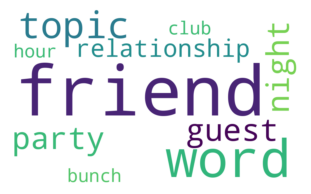

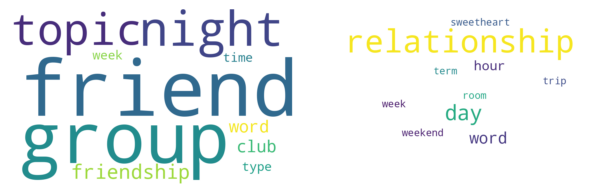

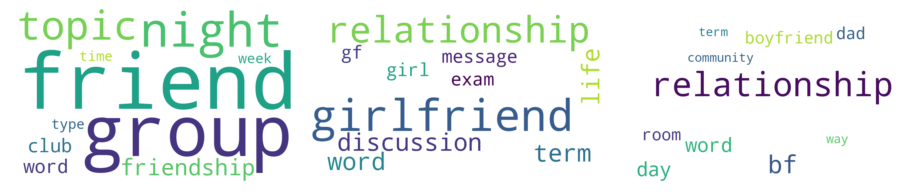

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TOPIC 2


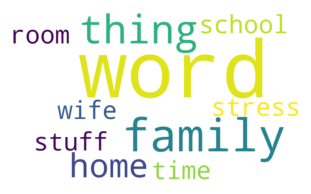

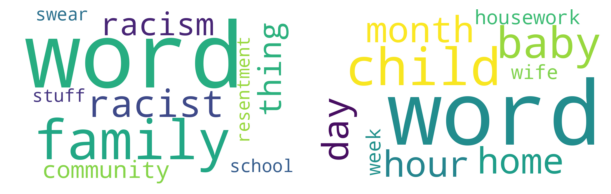

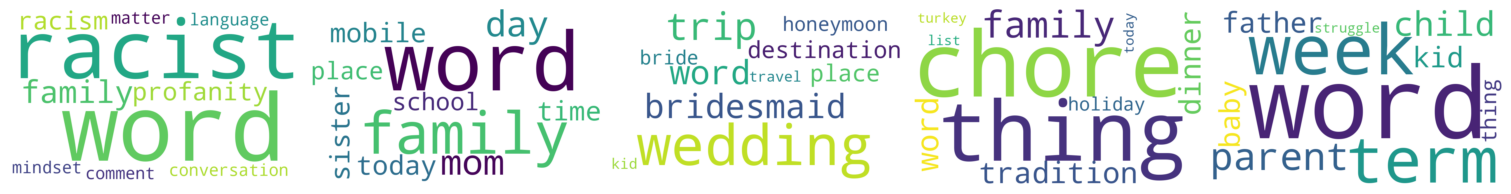

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TOPIC 3


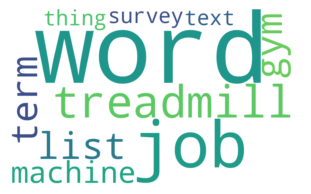

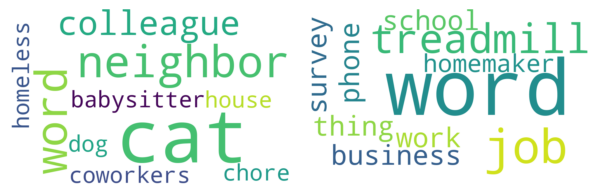

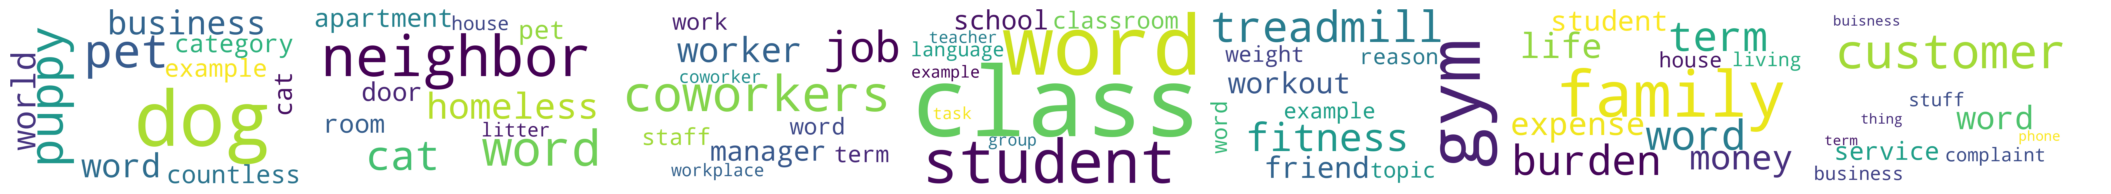

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


In [15]:
number_of_splits = len(thresholds)

for cluster_num in range(number_of_splits):
    print(f'TOPIC {cluster_num+1}')
    generate_word_clouds_for_splits(df_short, list_of_clusters, clusters_keyword, cluster_num=cluster_num, number_of_splits=number_of_splits, top_n_words=10)
    print('-*'*40)


## Who makes it to the top?

In [16]:
df_short.groupby('cluster_6')['num_upvotes'].describe(percentiles=[0.25,0.5,0.9])

,count,mean,std,min,25%,50%,90%,max
cluster_6,,,,,,,,
1,1491.0,141.977197,848.115607,2.0,3.0,6.0,96.0,16325.0
2,1461.0,202.760438,1198.802553,2.0,3.0,7.0,155.0,23147.0
3,2088.0,296.977969,1251.264951,2.0,5.0,12.0,378.6,20600.0
4,3059.0,622.162471,2194.035854,2.0,6.0,18.0,1451.0,41365.0
5,1095.0,324.173516,1468.770567,2.0,5.0,11.0,334.6,16783.0
6,3551.0,264.365249,1212.001369,2.0,4.0,10.0,355.0,22812.0


In [17]:
percentiles_99 = df_short.groupby('cluster_6')['num_upvotes'].quantile(0.99)

top_99_posts = df_short[df_short.apply(lambda row: row['num_upvotes'] > percentiles_99[row['cluster_6']], axis=1)]

print('Number of top 1 percent popular posts for each topic (6 split):')
top_99_posts.groupby('cluster_6')['num_upvotes'].describe()

Number of top 1 percent popular posts for each topic (6 split):


,count,mean,std,min,25%,50%,75%,max
cluster_6,,,,,,,,
1,15.0,7110.400000,3790.375703,3603.0,4400.50,5472.0,8170.5,16325.0
2,15.0,9483.133333,6152.905839,4740.0,5232.50,6560.0,10685.0,23147.0
3,21.0,9933.285714,4049.531098,5883.0,6881.00,8793.0,10410.0,20600.0
4,31.0,17111.580645,6864.839701,10384.0,12012.50,15388.0,20276.0,41365.0
5,11.0,12484.181818,2528.370891,9224.0,10704.50,11664.0,14398.5,16783.0
6,36.0,9859.194444,4392.572802,5702.0,6673.25,8086.0,13115.5,22812.0


## The best cluster representative... readable

**Identify the most representative text within a group of clustered data**. A function calculats the of all the text embeddings in a cluster and then finding the text that is closest to that centroid.

**Write a summery**. Once the most representative text is identified, LLM takes over. A function interacts Groq's API, and requests to generate a concise summary of the selected text. 

The two step approach help to distill complex content into clear representative.

In [18]:
def get_text_to_centroids(df, cluster_column, text_column, vector_column):
    
    embeddings = np.array(df[vector_column].tolist())

    # Initialize an empty list to store the most representative text for each cluster
    representative_texts = []

    # For each cluster, find the text closest to the centroid
    for cluster_num in sorted(df[cluster_column].unique()):
        # Get the embeddings of all texts in the cluster
        cluster_embeddings = embeddings[df[cluster_column] == cluster_num]
        
        # Ensure there are embeddings to process
        if len(cluster_embeddings) == 0:
            continue
        
        # Get the centroid of the cluster
        cluster_centroid = cluster_embeddings.mean(axis=0)
        
        # Find the index of the closest text to the centroid
        closest, _ = metrics.pairwise_distances_argmin_min([cluster_centroid], cluster_embeddings)
        
        # Get the original index of the closest text
        original_index = df[df[cluster_column] == cluster_num].index[closest[0]]
        
        # Append the most representative text (title or post) to the list
        representative_texts.append(df.loc[original_index, text_column])

    return representative_texts


In [28]:
from groq import Groq

# Groq API key
client_grq = Groq(api_key="YOUR_KEY")

def get_groq_response(prompt, instruction, model="gemma-7b-it"):
    
    try:

        completion = client_grq.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system","content": instruction
                },
                {
                    "role": "user", "content": prompt
                }
            ],
            temperature=0.2,
            max_tokens=500,
            top_p=1,
            stream=True,
            stop=None,
        )

        string = ''
        for chunk in completion:
            string += chunk.choices[0].delta.content or ""
        string = string.replace('\n', ' ')

        return string 

    except Exception as e:
        print(f"An error occurred: {e}")
        return "No information"  # or return None, based on how you want to handle errors



In [29]:
# Display the most representative text for each cluster
representative_texts =  get_text_to_centroids(top_99_posts, 'cluster_6',  'text', 'text_embeddings')

instr = 'Summarize the scenario of the text in 1-2 sentences.'

print("---------------------------------------------------------")

for i, text in enumerate(representative_texts):
    summary = get_groq_response(text, instr, model="gemma-7b-it")
    short_print(f"Cluster {i+1}: {summary}")

---------------------------------------------------------


Cluster 1: The author was advised by a coworker to get a karaoke machine for her friend's daughter's birthday, but later learned from the daughter that she wanted clothes or bags instead. Despite clarifying this with the daughter, the friend remained upset and accused the author of disrespect.


Cluster 2: The author's girlfriend threw him a surprise birthday party but bought him an expensive gaming laptop, causing conflict as he felt belittled by her financial display. He had a heated argument with her during the party and hasn't responded to her text.


Cluster 3: The author's sister criticized the author for asking her to clean up her son's mess, despite being pregnant. This resulted in a heated argument and a cold silence between them.


Cluster 4: The author's youngest daughter is planning a wedding to an older man, despite the author's disapproval. The author refuses to pay for the wedding as a consequence of her daughter's defiance and poor relationship choice.


Cluster 5: Bob, the husband of the narrator's best friend, was kicked out of his home and stayed at their place. He complained about an uncomfortable night on an air mattress despite being told he could not sleep on the comfortable sofa where the dogs sleep.


Cluster 6: A hair stylist received a rude request from her younger sister, who criticized her professionalism and attempted to manipulate her for free work. When the stylist charged for the haircuts, her sister reacted aggressively and called the police.


## Is there a combination topic that performs better?

In [27]:
# Group the data by cluster and calculate the mean upvotes for each cluster
cluster_popularity = top_99_posts.groupby('cluster_6')['num_upvotes'].mean().sort_values(ascending=False)

# Display the most popular clusters based on mean upvotes
print("Most Popular Clusters (by mean upvotes):")
print(cluster_popularity.head(10))  # Show top 10 clusters

Most Popular Clusters (by mean upvotes):
cluster_6
4    17111.580645
5    12484.181818
3     9933.285714
6     9859.194444
2     9483.133333
1     7110.400000
Name: num_upvotes, dtype: float64


In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd

# Perform ANOVA
model = ols('num_upvotes ~ C(cluster_6)', data=top_99_posts).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)



                    sum_sq     df          F        PR(>F)
C(cluster_6)  1.485269e+09    5.0  11.374818  4.938833e-09
Residual      3.212148e+09  123.0        NaN           NaN


## To be continued... 